# Setup, Libraries

Download sample images and a label typeface for this lab, by pasting and running the following command in a new cell. Each line begins with an exclamation point, which tells the kernel to run these bash commands within the notebook cells.

In [3]:
!mkdir sample_images
!wget https://storage.googleapis.com/generativeai-downloads/images/socks.jpg -O sample_images/Socks.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/vegetables.jpg -O sample_images/Vegetables.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png -O sample_images/Japanese_bento.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Cupcakes.jpg -O sample_images/Cupcakes.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/origamis.jpg -O sample_images/Origamis.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/fruits.jpg -O sample_images/Fruits.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/cat.jpg -O sample_images/Cat.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/pumpkins.jpg -O sample_images/Pumpkins.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/breakfast.jpg -O sample_images/Breakfast.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/bookshelf.jpg -O sample_images/Bookshelf.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/spill.jpg -O sample_images/Spill.jpg -q
!sudo apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 55.1 MB of archives.
After this operation, 91.3 MB of additional disk space will be used.
Get:1 https://deb.debian.org/debian bullseye/main amd64 fonts-noto-cjk all 1:20201206-cjk+repack1-1 [55.1 MB]
Fetched 55.1 MB in 1s (50.9 MB/s)          
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 144093 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20201206-cjk+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20201206-cjk+repack1-1) ...
Setting up fonts-noto-cjk (1:20201206-cjk+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2) ...


In [1]:
from PIL import Image

import io
import os
import requests
from io import BytesIO
import IPython
from IPython.display import Markdown, Video, display

from google import genai
from google.genai import types

from gemini_for_cv_utils import plot_bounding_boxes, parse_json, \
        parse_segmentation_masks, plot_segmentation_masks, generate_point_html, \
        get_url_from_gcs

In [4]:
os.environ

environ{'SHELL': '/bin/bash',
        'CONDA_EXE': '/opt/conda/bin/conda',
        '_CE_M': '',
        'VERTEX_PRODUCT': 'WORKBENCH_INSTANCE',
        'GRPC_FORK_SUPPORT_ENABLED': '0',
        'DL_ANACONDA_HOME': '/opt/conda',
        'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework',
        'GOOGLE_CLOUD_PROJECT': 'qwiklabs-gcp-04-27a9e1d9ae22',
        'POST_STARTUP_SCRIPT_PATH': '/opt/c2d/post_start.sh',
        'DL_PATH_DEPS': '/opt/deeplearning/deps',
        'DL_BIN_PATH': '/opt/deeplearning/bin',
        'XML_CATALOG_FILES': 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog',
        'KERNEL_LAUNCH_TIMEOUT': '598',
        'BINARIES_PATH': '/opt/deeplearning/binaries',
        'PWD': '/home/jupyter',
        'LOGNAME': 'jupyter',
        'CONDA_PREFIX': '/opt/conda',
        'JPY_SESSION_NAME': '/home/jupyter/Untitled.ipynb',
        'TENSORBOARD_PROXY_URL': '/proxy/%PORT%/',
        'GOOGLE_CLOUD_REGION': 'us-central1',
        'PACKAGE_SOURCE_CODE_PATH':

In [2]:
project_id, = !gcloud config get project
print(project_id)

client = genai.Client(vertexai=True,
                    project=project_id,
                    location="us-central1")

model_name = "gemini-2.5-flash"

qwiklabs-gcp-04-27a9e1d9ae22


# Task 2. Draw bounding boxes

In this task, you use the Gemini model to identify and label food items on a breakfast plate by generating bounding boxes around them. You define system instructions to control the format and content of the model's output, preview the input image, prompt the model to detect objects, and finally visualize the detected items by drawing the predicted bounding boxes on the image.



In [5]:
# set safety_settings to BLOCK_ONLY_HIGH dangerous content, minimizing the potential number of false alarms for content safety
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels.
    Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according
    to their unique characteristic (colors, size, position,
    unique characteristics, etc.).
    """

# Minimize safety-related errors
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

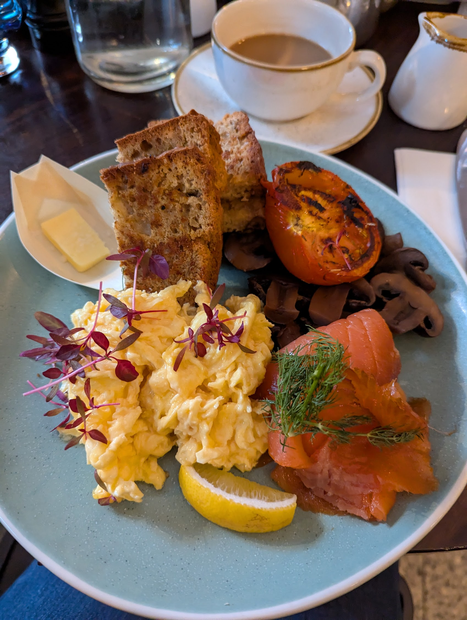

In [6]:
image = "sample_images/Breakfast.jpg"
im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

In [7]:
prompt = (
"Identify and label each distinct food item on the plate individually. "
"Return specific names such as 'scrambled eggs', 'toast', 'mushrooms', "
"'smoked salmon', etc., not generic labels like 'food items'."
)
# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

```json
[
  {"box_2d": [178, 218, 467, 492], "label": "toast"},
  {"box_2d": [174, 468, 376, 574], "label": "toast"},
  {"box_2d": [447, 102, 807, 584], "label": "scrambled eggs"},
  {"box_2d": [238, 568, 460, 818], "label": "grilled tomato"},
  {"box_2d": [368, 480, 555, 940], "label": "mushrooms"},
  {"box_2d": [496, 560, 843, 936], "label": "smoked salmon"},
  {"box_2d": [737, 384, 861, 638], "label": "lemon wedge"},
  {"box_2d": [336, 94, 437, 230], "label": "butter"},
  {"box_2d": [448, 40, 706, 542], "label": "purple microgreens"},
  {"box_2d": [530, 548, 735, 876], "label": "dill"},
  {"box_2d": [0, 452, 197, 824], "label": "coffee cup"},
  {"box_2d": [50, 490, 106, 712], "label": "coffee"},
  {"box_2d": [18, 830, 210, 1000], "label": "cream pitcher"},
  {"box_2d": [0, 138, 149, 408], "label": "water glass"},
  {"box_2d": [239, 138, 860, 998], "label": "plate"}
]
```


(771, 1024)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmp_ko7ru3x.PNG'


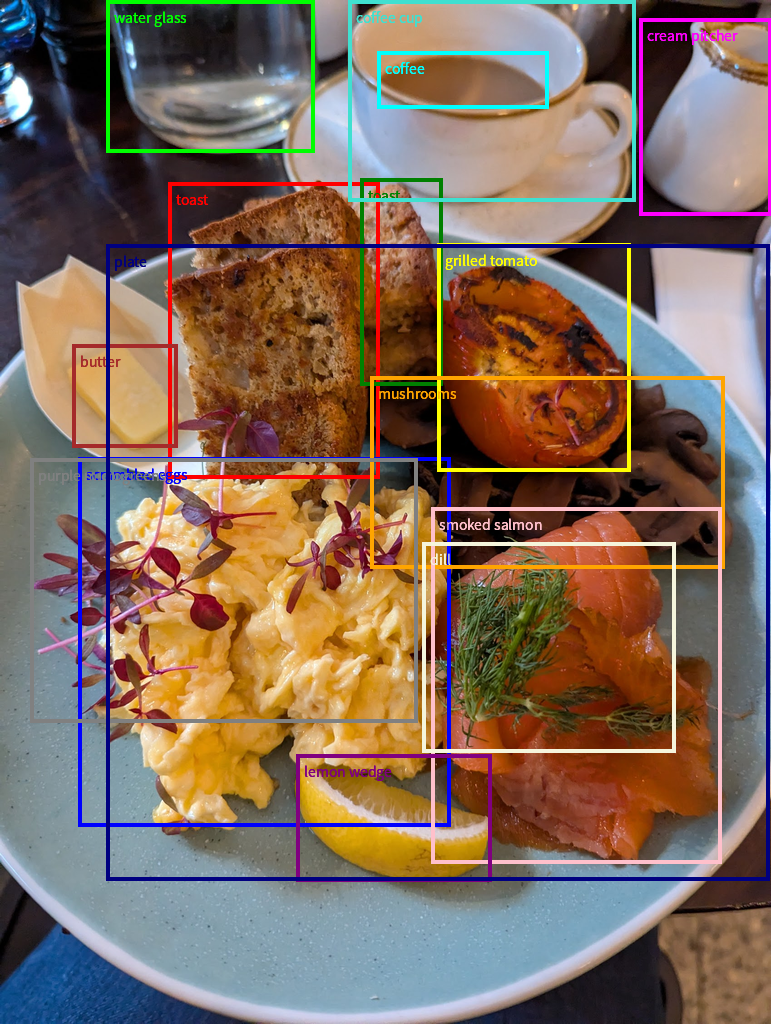

In [10]:
plot_bounding_boxes(im, response.text)
im

In [13]:
plot_bounding_boxes(im, response.text)

(771, 1024)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmpkhkkyi8t.PNG'


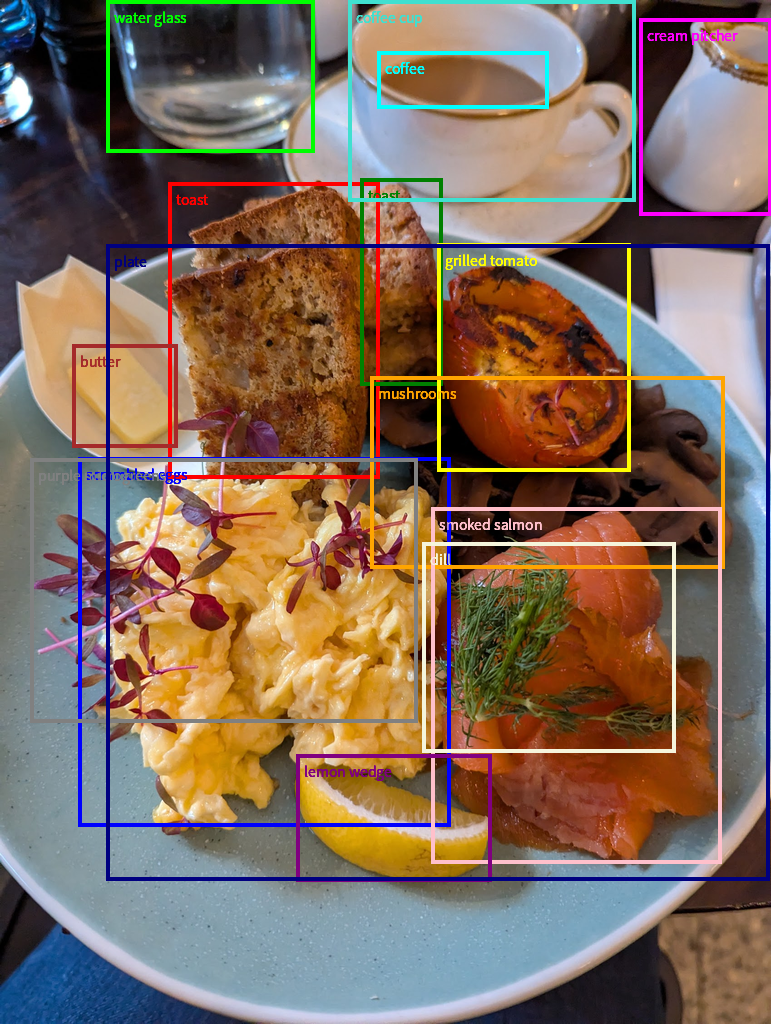

In [14]:
im

# Task 3. Use reasoning capabilities when labeling

In this task, you explore Gemini’s ability to apply visual reasoning by identifying and labeling objects based on more abstract or specific criteria, such as socks with faces or the shadow of a fox. Rather than detecting general object categories, the model uses natural language prompts to reason about the image content and return bounding boxes for only the relevant regions.



```json
[
  {"box_2d": [234, 638, 650, 862], "label": "right light blue sock with cat face"},
  {"box_2d": [53, 245, 385, 526], "label": "left light blue sock with cat face"}
]
```
(640, 482)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmpfz_4vt0t.PNG'


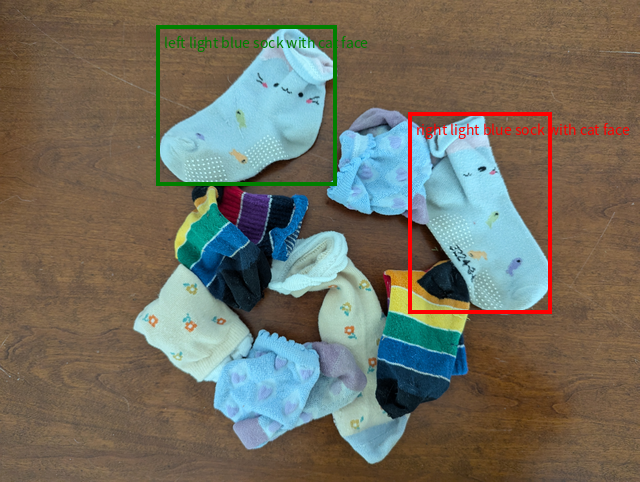

In [15]:
# find items that meet a particular criteria. Instead of needing to train a computer vision model on specific types of items, you can use Gemini's multimodal capabilities to select only certain items.
# This could be very useful in situations like reviewing camera footage for particular clothing or vehicles:


# Load and scale an image
image = "sample_images/Socks.jpg"
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Prompt model to find bounding boxes
prompt = "Show me the positions of socks with a face on them."

response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

(640, 482)


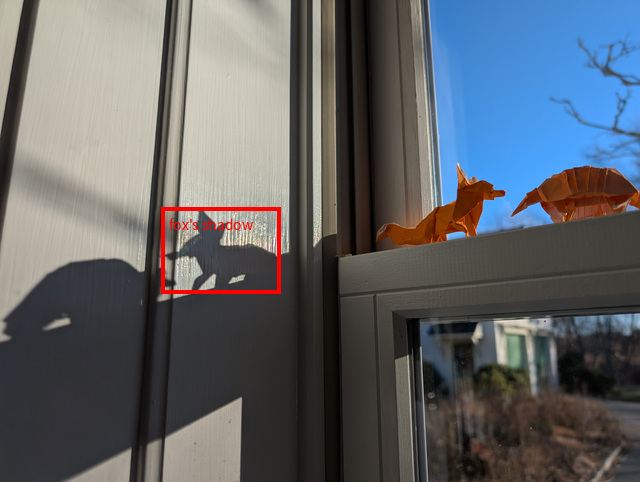

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmpte3_4e9i.PNG'


In [16]:
image = "sample_images/Origamis.jpg"
prompt = "Draw a square around the fox's shadow"

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

# Task 4. Understand objects use in a given situation

In this task, you use Gemini to interpret the practical use of objects within a real-world scene. Rather than identifying or labeling items generically, the model is prompted to explain how specific objects relate to a given situation. The output highlights key objects using points and descriptive labels, showcasing Gemini’s ability to combine visual understanding with contextual reasoning.




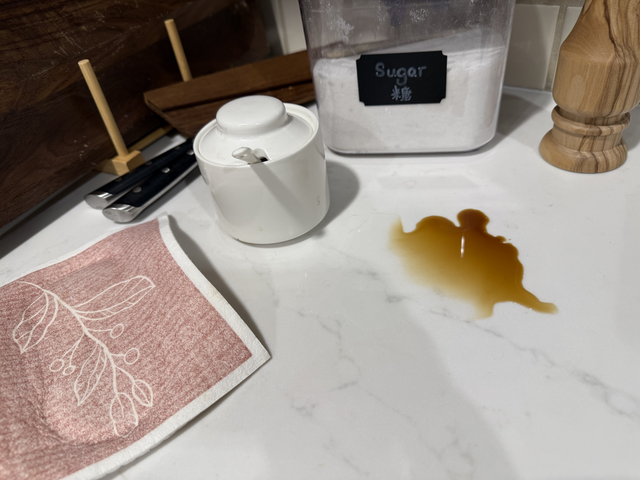

In [24]:
# Instead of drawing bounding boxes, this code will highlight specific objects via a point and a tooltip-style label
    
image = "sample_images/Spill.jpg"
prompt = "Tell me how to clean my table with an explanation as label. Do not just label the items"

point_instruction = """
The answer should follow the JSON format: [{"point": <point>, "label": <label>}].
The points are in [y, x] format normalized to 0-1000. One element per line.
Labels should include line breaks approximately every 30 characters.
"""

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=point_instruction,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Display points
IPython.display.HTML(generate_point_html(im, response.text))

# black image over multiple iterations


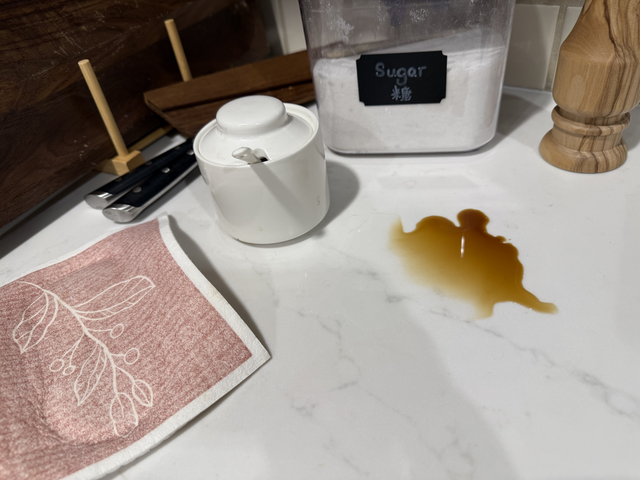

In [41]:
# Instead of drawing bounding boxes, this code will highlight specific objects via a point and a tooltip-style label
    
image = "sample_images/Spill.jpg"
prompt = "Tell me how to clean my table with an explanation as label. Do not just label the items"

point_instruction = """
The answer should follow the JSON format: [{"point": <point>, "label": <label>}].
The points are in [y, x] format normalized to 0-1000. One element per line.
Labels should include line breaks approximately every 30 characters.
"""

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=point_instruction,
        temperature=0.8,
        safety_settings=safety_settings,
    )
)

# Display points
IPython.display.HTML(generate_point_html(im, response.text))

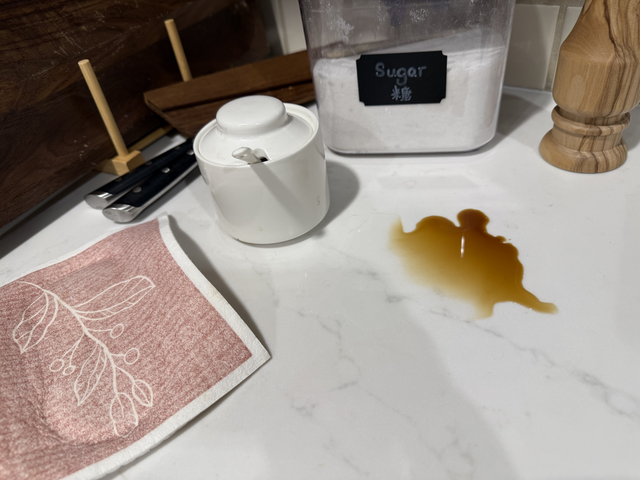

In [43]:
# # --- ADD THIS LINE FOR DEBUGGING ---
display(im) # This should show your resized image. If it doesn't, the 'im' object is the problem.

In [34]:
response

GenerateContentResponse(
  automatic_function_calling_history=[],
  candidates=[
    Candidate(
      avg_logprobs=-0.5754198556923005,
      content=Content(
        parts=[
          Part(
            text="""[
  {"point": [521, 696], "label": "First, address the spill promptly.\nThis appears to be a liquid spill, likely a dark syrup or coffee, which can stain if left too long.\nIf it's sticky, a damp cloth will be more effective."},
  {"point": [712, 187], "label": "Next, grab the cleaning cloth.\nThis pink cloth with a leaf design is perfect for wiping up the spill.\nMake sure it's clean and slightly damp for best results, especially if the spill is sticky.\nAvoid scrubbing aggressively, as this can spread the stain or damage the surface."},
  {"point": [706, 497], "label": "Gently wipe the spill.\nStart from the outside of the spill and work your way in to prevent spreading it further.\nBlotting can also be effective for absorbing the liquid without spreading.\nRepeat with a clean

In [37]:
response.text

'[\n  {"point": [521, 696], "label": "First, address the spill promptly.\\nThis appears to be a liquid spill, likely a dark syrup or coffee, which can stain if left too long.\\nIf it\'s sticky, a damp cloth will be more effective."},\n  {"point": [712, 187], "label": "Next, grab the cleaning cloth.\\nThis pink cloth with a leaf design is perfect for wiping up the spill.\\nMake sure it\'s clean and slightly damp for best results, especially if the spill is sticky.\\nAvoid scrubbing aggressively, as this can spread the stain or damage the surface."},\n  {"point": [706, 497], "label": "Gently wipe the spill.\\nStart from the outside of the spill and work your way in to prevent spreading it further.\\nBlotting can also be effective for absorbing the liquid without spreading.\\nRepeat with a clean section of the cloth or rinse the cloth if needed."},\n  {"point": [862, 597], "label": "After removing the bulk of the spill, wipe the area again with a clean, damp cloth to remove any residue.\\


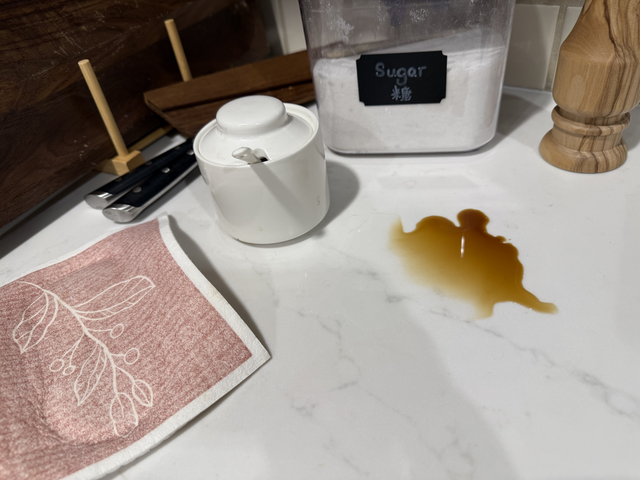

In [44]:
IPython.display.HTML(generate_point_html(im, response.text))

## Fix Rendering of annotation and image

In [50]:
# Corrected function
def generate_point_html2(pil_image, points_json):
    # Convert PIL image to base64 string
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    # --- FIX STARTS HERE ---
    # First, parse the string from the model into a Python object
    points_data = json.loads(parse_json(points_json))
    # Then, dump it back into a string that is guaranteed to be valid JavaScript/JSON.
    # This correctly escapes newlines, quotes, etc.
    valid_js_json = json.dumps(points_data)
    # --- FIX ENDS HERE ---


    # Note the change from {points_json} to {valid_js_json} below
    # Also, I've removed the redundant, second call to annotatePoints() at the end of the script
    # to fix a race condition.
    return f"""
<!DOCTYPE html>
<html>
<head>
    <title>Point Visualization</title>
    <style>
        /* CSS styles remain the same */
        body {{ margin: 0; padding: 0; }}
        .point-overlay {{ position: absolute; top: 0; left: 0; width: 100%; height: 100%; pointer-events: none; }}
        .point {{ position: absolute; width: 12px; height: 12px; background-color: #2962FF; border: 2px solid #fff; border-radius: 50%; transform: translate(-50%, -50%); box-shadow: 0 0 40px rgba(41, 98, 255, 0.6); opacity: 0; transition: all 0.3s ease-in; pointer-events: auto; }}
        .point.visible {{ opacity: 1; }}
        .point.fade-out {{ animation: pointFadeOut 0.3s forwards; }}
        .point.highlight {{ transform: translate(-50%, -50%) scale(1.1); background-color: #FF4081; box-shadow: 0 0 40px rgba(255, 64, 129, 0.6); z-index: 100; }}
        @keyframes pointFadeOut {{ from {{ opacity: 1; }} to {{ opacity: 0.7; }} }}
        .point-label {{ position: absolute; background-color: #2962FF; color: #fff; font-size: 14px; padding: 4px 12px; border-radius: 4px; transform: translate(20px, -10px); white-space: nowrap; opacity: 0; transition: all 0.3s ease-in; box-shadow: 0 0 30px rgba(41, 98, 255, 0.4); pointer-events: auto; cursor: pointer; }}
        .point-label.visible {{ opacity: 1; }}
        .point-label.fade-out {{ opacity: 0.45; }}
        .point-label.highlight {{ background-color: #FF4081; box-shadow: 0 0 30px rgba(255, 64, 129, 0.4); transform: translate(20px, -10px) scale(1.1); z-index: 100; }}
    </style>
</head>
<body>
    <div id="container" style="position: relative;">
        <canvas id="canvas" style="background: #000;"></canvas>
        <div id="pointOverlay" class="point-overlay"></div>
    </div>

    <script>
        function annotatePoints(frame) {{
            const pointsData = {valid_js_json}; // Use the sanitized JSON string
            const pointOverlay = document.getElementById('pointOverlay');
            pointOverlay.innerHTML = '';
            const points = [];
            const labels = [];
            pointsData.forEach(pointData => {{
                if (!pointData.hasOwnProperty("point")) return;
                const point = document.createElement('div');
                point.className = 'point';
                const [y, x] = pointData.point;
                point.style.left = `${{x/1000.0 * 100.0}}%`;
                point.style.top = `${{y/1000.0 * 100.0}}%`;
                const pointLabel = document.createElement('div');
                pointLabel.className = 'point-label';
                pointLabel.textContent = pointData.label;
                point.appendChild(pointLabel);
                pointOverlay.appendChild(point);
                points.push(point);
                labels.push(pointLabel);
                setTimeout(() => {{
                    point.classList.add('visible');
                    pointLabel.classList.add('visible');
                }}, 0);
                const handleMouseEnter = () => {{
                    point.classList.add('highlight');
                    pointLabel.classList.add('highlight');
                    points.forEach((p, idx) => {{
                        if (p !== point) {{
                            p.classList.add('fade-out');
                            labels[idx].classList.add('fade-out');
                        }}
                    }});
                }};
                const handleMouseLeave = () => {{
                    point.classList.remove('highlight');
                    pointLabel.classList.remove('highlight');
                    points.forEach((p, idx) => {{
                        p.classList.remove('fade-out');
                        labels[idx].classList.remove('fade-out');
                    }});
                }};
                point.addEventListener('mouseenter', handleMouseEnter);
                point.addEventListener('mouseleave', handleMouseLeave);
                pointLabel.addEventListener('mouseenter', handleMouseEnter);
                pointLabel.addEventListener('mouseleave', handleMouseLeave);
            }});
        }}

        const canvas = document.getElementById('canvas');
        const ctx = canvas.getContext('2d');
        const container = document.getElementById('container');
        const img = new Image();
        img.onload = () => {{
            const aspectRatio = img.height / img.width;
            canvas.width = 800;
            canvas.height = Math.round(800 * aspectRatio);
            container.style.width = canvas.width + 'px';
            container.style.height = canvas.height + 'px';
            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);
            const frame = {{ width: canvas.width, height: canvas.height }};
            annotatePoints(frame); // Call this ONLY after the image is loaded and canvas is sized
        }};
        img.src = 'data:image/png;base64,{img_str}';
    </script>
</body>
</html>
"""

In [47]:
import json
import base64
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont, ImageColor

# Now, when you call this function, it will work correctly.
# This is a placeholder for your actual model response text
response_text = '[\n  {"point": [521, 696], "label": "First, address the spill promptly.\\nThis appears to be a liquid spill, likely a dark syrup or coffee, which can stain if left too long.\\nIf it\'s sticky, a damp cloth will be more effective."},\n  {"point": [712, 187], "label": "Next, grab the cleaning cloth.\\nThis pink cloth with a leaf design is perfect for wiping up the spill.\\nMake sure it\'s clean and slightly damp for best results, especially if the spill is sticky.\\nAvoid scrubbing aggressively, as this can spread the stain or damage the surface."},\n  {"point": [706, 497], "label": "Gently wipe the spill.\\nStart from the outside of the spill and work your way in to prevent spreading it further.\\nBlotting can also be effective for absorbing the liquid without spreading.\\nRepeat with a clean section of the cloth or rinse the cloth if needed."},\n  {"point": [862, 597], "label": "After removing the bulk of the spill, wipe the area again with a clean, damp cloth to remove any residue.\\nIf the spill was sugary or sticky, this step is crucial to prevent attracting pests or leaving a tacky film.\\nFinish by drying the area with a clean, dry cloth to prevent water spots and ensure the surface is completely clean."},\n  {"point": [291, 407], "label": "Once the table is clean, put away any items that might have been moved.\\nHere, the sugar container, knives, and wooden stand can be returned to their original positions."},\n  {"point": [229, 620], "label": "Ensure all items are properly stored to maintain a tidy and organized kitchen space.\\nThis also helps prevent future spills or accidents."}\n]'

# This is a placeholder for your actual image
try:
    im = Image.open("sample_images/Spill.jpg")
    im.thumbnail([640,640], Image.Resampling.LANCZOS)
    # This will now generate the correct HTML with valid JavaScript
    html_output = generate_point_html2(im, response_text)
    print("HTML generated successfully. The image should now render correctly.")
    # In a real notebook, you would do:
    # from IPython.display import HTML
    # HTML(html_output)
except FileNotFoundError:
    print("Please ensure 'sample_images/Spill.jpg' exists to run this example.")


HTML generated successfully. The image should now render correctly.



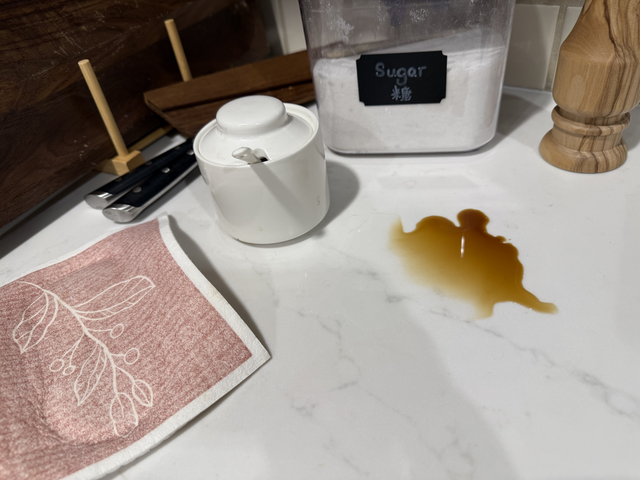

In [48]:
IPython.display.HTML(generate_point_html2(im, response.text))

In [51]:
import re # Import the regular expression module

def generate_point_html3(pil_image, model_output_text):
    # --- NEW, MORE ROBUST JSON EXTRACTION ---
    # Find the first occurrence of a string that starts with '[' and ends with ']'
    # re.DOTALL makes the '.' character match newlines as well.
    json_match = re.search(r"\[.*\]", model_output_text, re.DOTALL)

    if not json_match:
        print("ERROR: Could not find a JSON array '[...]' in the model's output.")
        # Create an empty JSON array to prevent the script from crashing
        valid_js_json = "[]"
    else:
        json_string = json_match.group(0)
        try:
            # Now we load and dump the extracted string to ensure it's perfectly formatted
            points_data = json.loads(json_string)
            valid_js_json = json.dumps(points_data)
        except json.JSONDecodeError as e:
            print(f"ERROR: Failed to decode the extracted JSON. Error: {e}")
            print(f"Extracted Text: {json_string}")
            valid_js_json = "[]"

    # --- The rest of the function is the same ---
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    return f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Point Visualization</title>
        <style>
            /* CSS styles remain the same */
            body {{ margin: 0; padding: 0; }} .point-overlay {{ position: absolute; top: 0; left: 0; width: 100%; height: 100%; pointer-events: none; }} .point {{ position: absolute; width: 12px; height: 12px; background-color: #2962FF; border: 2px solid #fff; border-radius: 50%; transform: translate(-50%, -50%); box-shadow: 0 0 40px rgba(41, 98, 255, 0.6); opacity: 0; transition: all 0.3s ease-in; pointer-events: auto; }} .point.visible {{ opacity: 1; }} .point.fade-out {{ animation: pointFadeOut 0.3s forwards; }} .point.highlight {{ transform: translate(-50%, -50%) scale(1.1); background-color: #FF4081; box-shadow: 0 0 40px rgba(255, 64, 129, 0.6); z-index: 100; }} @keyframes pointFadeOut {{ from {{ opacity: 1; }} to {{ opacity: 0.7; }} }} .point-label {{ position: absolute; background-color: #2962FF; color: #fff; font-size: 14px; padding: 4px 12px; border-radius: 4px; transform: translate(20px, -10px); white-space: nowrap; opacity: 0; transition: all 0.3s ease-in; box-shadow: 0 0 30px rgba(41, 98, 255, 0.4); pointer-events: auto; cursor: pointer; }} .point-label.visible {{ opacity: 1; }} .point-label.fade-out {{ opacity: 0.45; }} .point-label.highlight {{ background-color: #FF4081; box-shadow: 0 0 30px rgba(255, 64, 129, 0.4); transform: translate(20px, -10px) scale(1.1); z-index: 100; }}
        </style>
    </head>
    <body>
        <div id="container" style="position: relative;">
            <canvas id="canvas" style="background: #000;"></canvas>
            <div id="pointOverlay" class="point-overlay"></div>
        </div>
        <script>
            function annotatePoints(frame) {{
                const pointsData = {valid_js_json};
                const pointOverlay = document.getElementById('pointOverlay');
                pointOverlay.innerHTML = ''; const points = []; const labels = [];
                pointsData.forEach(pointData => {{
                    if (!pointData.hasOwnProperty("point")) return;
                    const point = document.createElement('div'); point.className = 'point';
                    const [y, x] = pointData.point;
                    point.style.left = `${{x/1000.0 * 100.0}}%`; point.style.top = `${{y/1000.0 * 100.0}}%`;
                    const pointLabel = document.createElement('div'); pointLabel.className = 'point-label'; pointLabel.textContent = pointData.label;
                    point.appendChild(pointLabel); pointOverlay.appendChild(point);
                    points.push(point); labels.push(pointLabel);
                    setTimeout(() => {{ point.classList.add('visible'); pointLabel.classList.add('visible'); }}, 0);
                    const handleMouseEnter = () => {{ point.classList.add('highlight'); pointLabel.classList.add('highlight'); points.forEach((p, idx) => {{ if (p !== point) {{ p.classList.add('fade-out'); labels[idx].classList.add('fade-out'); }} }}); }};
                    const handleMouseLeave = () => {{ point.classList.remove('highlight'); pointLabel.classList.remove('highlight'); points.forEach((p, idx) => {{ p.classList.remove('fade-out'); labels[idx].classList.remove('fade-out'); }}); }};
                    point.addEventListener('mouseenter', handleMouseEnter); point.addEventListener('mouseleave', handleMouseLeave);
                    pointLabel.addEventListener('mouseenter', handleMouseEnter); pointLabel.addEventListener('mouseleave', handleMouseLeave);
                }});
            }}
            const canvas = document.getElementById('canvas'); const ctx = canvas.getContext('2d');
            const container = document.getElementById('container'); const img = new Image();
            img.onload = () => {{
                const aspectRatio = img.height / img.width;
                canvas.width = 800; canvas.height = Math.round(800 * aspectRatio);
                container.style.width = canvas.width + 'px'; container.style.height = canvas.height + 'px';
                ctx.drawImage(img, 0, 0, canvas.width, canvas.height);
                const frame = {{ width: canvas.width, height: canvas.height }};
                annotatePoints(frame);
            }};
            img.src = 'data:image/png;base64,{img_str}';
        </script>
    </body>
    </html>
    """


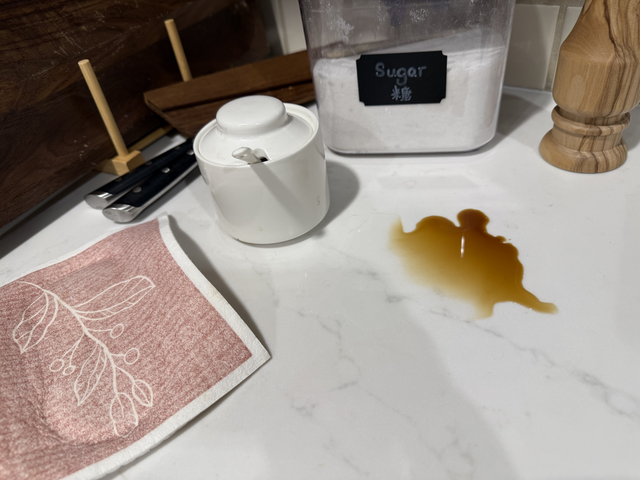

In [52]:
# In your notebook cell
IPython.display.HTML(generate_point_html3(im, response.text))

In [53]:
import re
import json
import base64
from io import BytesIO
from PIL import Image

def generate_point_html_final(pil_image, model_output_text):
    """
    Generates a self-contained HTML file to display points on an image.
    This version is robust against JSON errors and JavaScript scope conflicts in notebooks.
    """
    # --- Robust JSON Extraction ---
    json_match = re.search(r"\[.*\]", model_output_text, re.DOTALL)
    if not json_match:
        print("ERROR: Could not find a JSON array '[...]' in the model's output.")
        valid_js_json = "[]"
    else:
        json_string = json_match.group(0)
        try:
            points_data = json.loads(json_string)
            valid_js_json = json.dumps(points_data)
        except json.JSONDecodeError:
            print(f"ERROR: Failed to decode the extracted JSON: {json_string}")
            valid_js_json = "[]"

    # --- Image to Base64 ---
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    # --- HTML and JavaScript with IIFE Wrapper ---
    return f"""
    <!DOCTYPE html>
    <html>
    <head><title>Point Visualization</title>
        <style>
            body {{ margin: 0; padding: 0; }} .point-overlay {{ position: absolute; top: 0; left: 0; width: 100%; height: 100%; pointer-events: none; }} .point {{ position: absolute; width: 12px; height: 12px; background-color: #2962FF; border: 2px solid #fff; border-radius: 50%; transform: translate(-50%, -50%); box-shadow: 0 0 40px rgba(41, 98, 255, 0.6); opacity: 0; transition: all 0.3s ease-in; pointer-events: auto; }} .point.visible {{ opacity: 1; }} .point.fade-out {{ animation: pointFadeOut 0.3s forwards; }} .point.highlight {{ transform: translate(-50%, -50%) scale(1.1); background-color: #FF4081; box-shadow: 0 0 40px rgba(255, 64, 129, 0.6); z-index: 100; }} @keyframes pointFadeOut {{ from {{ opacity: 1; }} to {{ opacity: 0.7; }} }} .point-label {{ position: absolute; background-color: #2962FF; color: #fff; font-size: 14px; padding: 4px 12px; border-radius: 4px; transform: translate(20px, -10px); white-space: nowrap; opacity: 0; transition: all 0.3s ease-in; box-shadow: 0 0 30px rgba(41, 98, 255, 0.4); pointer-events: auto; cursor: pointer; }} .point-label.visible {{ opacity: 1; }} .point-label.fade-out {{ opacity: 0.45; }} .point-label.highlight {{ background-color: #FF4081; box-shadow: 0 0 30px rgba(255, 64, 129, 0.4); transform: translate(20px, -10px) scale(1.1); z-index: 100; }}
        </style>
    </head>
    <body>
        <div id="container" style="position: relative;">
            <canvas id="canvas" style="background: #000;"></canvas>
            <div id="pointOverlay" class="point-overlay"></div>
        </div>
        <script>
            (function() {{ // <--- START OF THE IIFE WRAPPER

                function annotatePoints(frame) {{
                    const pointsData = {valid_js_json};
                    const pointOverlay = document.getElementById('pointOverlay');
                    pointOverlay.innerHTML = ''; const points = []; const labels = [];
                    pointsData.forEach(pointData => {{
                        if (!pointData.hasOwnProperty("point")) return;
                        const point = document.createElement('div'); point.className = 'point';
                        const [y, x] = pointData.point;
                        point.style.left = `${{x/1000.0 * 100.0}}%`; point.style.top = `${{y/1000.0 * 100.0}}%`;
                        const pointLabel = document.createElement('div'); pointLabel.className = 'point-label'; pointLabel.textContent = pointData.label;
                        point.appendChild(pointLabel); pointOverlay.appendChild(point);
                        points.push(point); labels.push(pointLabel);
                        setTimeout(() => {{ point.classList.add('visible'); pointLabel.classList.add('visible'); }}, 10);
                        const handleMouseEnter = () => {{ point.classList.add('highlight'); pointLabel.classList.add('highlight'); points.forEach((p, idx) => {{ if (p !== point) {{ p.classList.add('fade-out'); labels[idx].classList.add('fade-out'); }} }}); }};
                        const handleMouseLeave = () => {{ point.classList.remove('highlight'); pointLabel.classList.remove('highlight'); points.forEach((p, idx) => {{ p.classList.remove('fade-out'); labels[idx].classList.remove('fade-out'); }}); }};
                        point.addEventListener('mouseenter', handleMouseEnter); point.addEventListener('mouseleave', handleMouseLeave);
                        pointLabel.addEventListener('mouseenter', handleMouseEnter); pointLabel.addEventListener('mouseleave', handleMouseLeave);
                    }});
                }}

                const canvas = document.getElementById('canvas');
                const ctx = canvas.getContext('2d');
                const container = document.getElementById('container');
                const img = new Image();

                img.onload = () => {{
                    const aspectRatio = img.height / img.width;
                    canvas.width = 800;
                    canvas.height = Math.round(800 * aspectRatio);
                    container.style.width = canvas.width + 'px';
                    container.style.height = canvas.height + 'px';
                    ctx.drawImage(img, 0, 0, canvas.width, canvas.height);
                    const frame = {{ width: canvas.width, height: canvas.height }};
                    annotatePoints(frame);
                }};

                img.src = 'data:image/png;base64,{img_str}';

            }})(); // <--- END OF THE IIFE WRAPPER
        </script>
    </body>
    </html>
    """


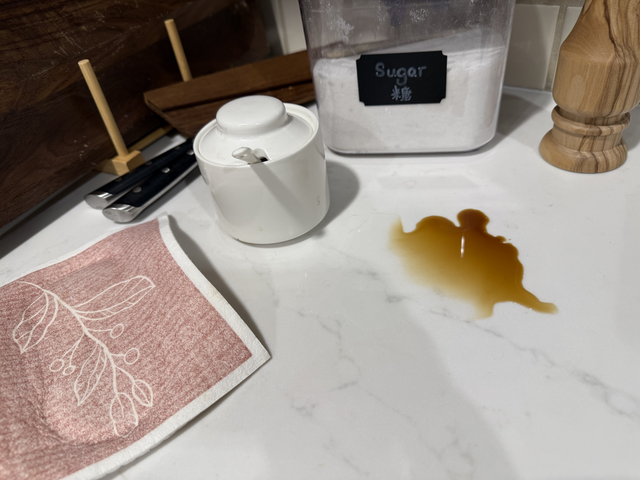

In [54]:
# In your notebook cell
IPython.display.HTML(generate_point_html_final(im, response.text))

Expected output annotated image
![Expected output annotated image](https://cdn.qwiklabs.com/3NTTu6VHVsiwE%2Fub3iVKUZ6MrY1dyRNFS%2FUW2Vowcvw%3D)